In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import math

from scipy.io import wavfile     # wave read
from scipy.fftpack import fft
from scipy.fftpack import ifft

from audio_utils import *

In [2]:
sound_file = './record/test1.wav'
#play_wav(sound_file)

### time domain

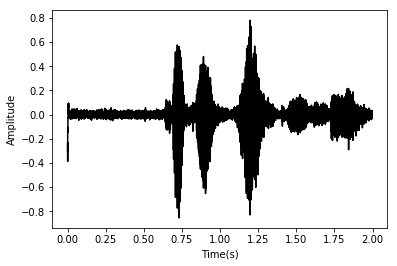

In [3]:
fs, sig = wavfile.read(sound_file)
sig_scale = sig / (2.**15)
sig_len = len(sig_scale)

time_array = np.arange(0,sig_len,1) / float(fs)

plt.figure()
plt.plot(time_array, sig_scale, color='k')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.show()

### frequency domain

In [4]:
fft_sig = fft(sig_scale)

half_sig_len = int(math.ceil((sig_len + 1) / 2.0))
abs_fft_sig = abs(fft_sig[0:half_sig_len])

abs_fft_sig = abs_fft_sig / float(sig_len)
abs_fft_sig = abs_fft_sig **2

if sig_len % 2 > 0: # odd number of points fft
    abs_fft_sig[1:len(abs_fft_sig)] = abs_fft_sig[1:len(abs_fft_sig)] * 2
else: # even
    abs_fft_sig[1:len(abs_fft_sig) - 1] = abs_fft_sig[1:len(abs_fft_sig) - 1] * 2 
    

sig_freqs = np.arange(0, half_sig_len, 1.0) * (float(fs) / sig_len)

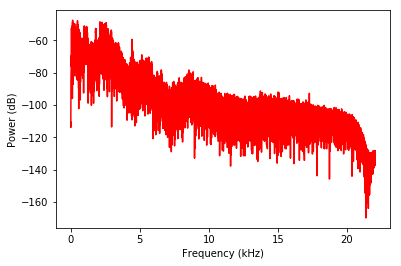

In [5]:
plt.figure()
plt.plot(sig_freqs/1000.0, 10 * np.log10(abs_fft_sig), color='r')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')
plt.show()

### Spectrogram

In [6]:
from scipy import signal

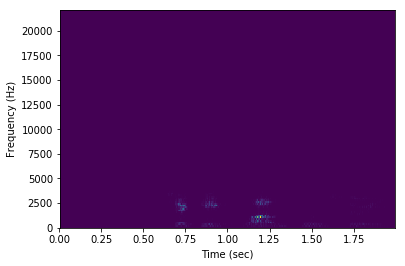

In [7]:
f, t, Sxx = signal.spectrogram(sig_scale, fs)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

## spectral subtraction

In [8]:
Srate, mysig = wavfile.read(sound_file)
mysig = mysig / (2.**15)  # rescale

In [9]:
framesize = math.floor(20*Srate/1000) # Frame size in sample
framesize = int(framesize)
print('frame size {}'.format(framesize))
if framesize % 2 == 1: framesize = framesize + 1
print('frame size {}'.format(framesize))

frame size 882
frame size 882


In [10]:
ovlp = 0.5 #window overlap in percent of frame siz
len1 = int(math.floor(framesize * ovlp))
print('len1 {}'.format(len1))
len2 = framesize - len1
print('len2 {}'.format(len2))

len1 441
len2 441


In [11]:
Thres=3 # VAD threshold in dB SNRseg 
alpha=2.0 # power exponent
FLOOR=0.002
G=0.9

In [12]:
win=np.hanning(framesize)  #define window
print win.shape
print win[0]
print sum(win)
winGain=len2/sum(win); # normalization gain for overlap+add with 50% overlap
print winGain

(882,)
0.0
440.5
1.00113507378


In [13]:
# Noise magnitude calculations - assuming that the first 5 frames is noise/silenc
nFFT= 2 * nextpow2(framesize)
print nFFT

noise_mean=np.zeros(nFFT)
print('noise_mean shape {}'.format(noise_mean.shape))

j=0
for k in range(5):
    win_frame = mysig[j:j+int(framesize)] * win
    #print('windowed frame {}'.format(win_frame.shape))
    
    myfft = fft(win_frame,nFFT)
    #print('myfft shape {}'.format(myfft.shape))
    #print myfft[0]
    
    myfft_abs = abs(myfft)
    #print('abs fft shape {}'.format(myfft_abs.shape))
    
    noise_mean = noise_mean + myfft_abs
    #print noise_mean.shape
    
    j=j+int(framesize)

noise_mu=noise_mean / 5.0
print('noise_mu shape {}'.format(noise_mu.shape))
print noise_mu[0]

2048
noise_mean shape (2048,)
noise_mu shape (2048,)
1.47635198242


In [14]:
import cmath

img = cmath.sqrt(-1)
print('img {}'.format(img))

x_old=np.zeros(len1)
print x_old.shape

Nframes= int(math.floor(len(mysig)/len2)-1)
print Nframes

xfinal=np.zeros(Nframes*len2)
print xfinal.shape

img 1j
(441,)
198
(87318,)


In [15]:
def berouti(SNR):
    if -5.0 <= SNR <= 20:
        a = 4 - SNR * 3.0 / 20                                                           
    elif SNR<-5.0:                                                                
        a=5.0                                                                                                                                                
    else: # > 20
        a=1.0 
    return a

def berouti1(SNR):
    if -5.0 <= SNR <= 20:
        a = 3 - SNR * 2.0 / 20                                                           
    elif SNR<-5.0:                                                                
        a=4.0                                                                                                                                                
    else: # > 20
        a=1.0 
    return a


In [16]:
count = 0

k = 0
for n in range(Nframes):
    
    insign = win * mysig[k:k+framesize]  # windowing
    print insign.shape
    #print insign[0]
    
    spec = fft(insign,nFFT);     # compute fourier transform of a frame
    print('spec shape {}'.format(spec.shape))
    
    sig_abs = abs(spec); # compute the magnitude

    #save the noisy phase information 
    theta=np.angle(spec)
    print('theta shape {}'.format(theta.shape))
    
#     #norm(sig,2)
    
    pow_sig = np.linalg.norm(sig_abs)
    print pow_sig

    pow_noise = np.linalg.norm(noise_mu)
    print pow_noise

    SNRseg=20*np.log10(pow_sig/pow_noise)
    print('SNRseg {}'.format(SNRseg))
    
    # when alpha = 2.0
    if alpha == 1.0:
        beta = berouti1(SNRseg)
    else:
        beta = berouti(SNRseg)
    print('beta {}'.format(beta))

    
    
#     print mysig.shape
#     print noise_mu.shape
    
    sub_speech = sig_abs**alpha - beta * noise_mu**alpha
    
    print('sub_speech shape {}'.format(sub_speech.shape))
    print sub_speech[0]
    
    
    diffw = sub_speech - FLOOR * (noise_mu**alpha)
    print('diffw shape {}'.format(diffw.shape))
    print diffw[0]
    
    
    ## floor negative components
    z = [idx for idx, val in enumerate(diffw) if val < 0.0]
    print len(z)
    #print z[:5]
    
    if not z:
        for idx in z:
            sub_speech[z] = FLOOR * (noise_mu[idx]**alpha) 
    
    print('sub_speech shape {}'.format(sub_speech.shape))

    #
    # a simple VAD
    #
    print('SNRseg {} Thres {}'.format(SNRseg, Thres))
    if SNRseg < Thres:
        noise_temp = G * (noise_mu**alpha) + (1-G) * (sig_abs**alpha);
        print noise_temp
        
        noise_mu=noise_temp**(1.0/alpha);   # new noise spectrum
        print noise_mu
        
    # to ensure conjugate symmetry for real reconstruction
    sub_speech[nFFT/2+1:nFFT]=np.flipud(sub_speech[1:nFFT/2]);  
    
    # 
    inv_alpha = 1.0 / alpha
    print('inv_alpha {}'.format(inv_alpha))
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    print cos_theta[:2]
    print sin_theta[:2]
    
    local_rad = (cos_theta + img * sin_theta);
    print('loc rad shape {}'.format(local_rad.shape))
    #print local_rad[:2]
    
    ## fix 'invalid value encountered in sqrt' by flooring the sub_speech
    for idx, val in enumerate(sub_speech):
        if val < 1e-6:
            sub_speech[idx] = 1e-6
    
    local_speech = sub_speech**inv_alpha
    print('local_speech shape {}'.format(local_speech.shape))
    #print local_speech[:2]
    
    
    x_phase = local_speech * local_rad
    print('x_phase shape {}'.format(x_phase.shape))
    print x_phase[:2]
    
    #
    # take inverse fft
    # 
    xi=np.real(ifft(x_phase))
    print('xi shape {}'.format(xi.shape))
    print xi[:2]
    
    #
    # overlapp and update
    #
    print('frame size {}'.format(framesize))
    
    xfinal[k:k+len2] = x_old + xi[:len1];
    x_old = xi[len1:framesize]
    #print x_old.shape
    
    
    k = k + len2
    
    count += 1
#     if count == 1: break

(882,)
spec shape (2048,)
theta shape (2048,)
21.8238679593
12.7007725663
SNRseg 4.70203172452
beta 3.29469524132
sub_speech shape (2048,)
22.723207887
diffw shape (2048,)
22.7188486567
1963
sub_speech shape (2048,)
SNRseg 4.70203172452 Thres 3
inv_alpha 0.5
[ 1.          0.74532659]
[ 0.         -0.66669953]
loc rad shape (2048,)
local_speech shape (2048,)
x_phase shape (2048,)
[ 4.76688660+0.j          3.60121791-3.22131308j]
xi shape (2048,)
[-0.0009534  -0.00066789]
frame size 882
(882,)
spec shape (2048,)
theta shape (2048,)
10.8733369661
12.7007725663
SNRseg -1.34934584137
beta 4.20240187621
sub_speech shape (2048,)
-9.0613328885
diffw shape (2048,)
-9.06569211886
1892
sub_speech shape (2048,)
SNRseg -1.34934584137 Thres 3
[ 1.97148226  2.56581215  3.61018612 ...,  4.12884757  3.61018612
  2.56581215]
[ 1.40409482  1.60181527  1.90004898 ...,  2.03195659  1.90004898
  1.60181527]
inv_alpha 0.5
[ 1.         -0.52733498]
[ 0.         -0.84965747]
loc rad shape (2048,)
local_speech 

In [17]:
#
# save the output: xfinal
#
output_sig = winGain * xfinal

wavfile.write('./record/test1-clean.wav', Srate, output_sig)